In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [2]:
table_model = YOLO("models/table_yolo_v11_20e.pt")
ball_model = YOLO("models/ball_best_v11_15e.pt")

In [3]:
# results = table_model("test_data/test7.png", save=True)
# print("Processed video saved at:", results[0].save_dir)

In [4]:
def order_points_stable(pts):
    pts = np.array(pts, dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    return np.array([
        pts[np.argmin(s)],      # top-left
        pts[np.argmin(diff)],   # top-right
        pts[np.argmax(diff)],   # bottom-left
        pts[np.argmax(s)],      # bottom-right
    ], dtype="float32")

### Pixel values in the original image
top-left , top-right, bottom-left , bottom-right
input_points = np.float32([[300, 128], [805, 119], [80, 636], [1047, 627]])

In [5]:
def warp_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read {image_path}")
        return

    img_height, img_width = img.shape[:2]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 1. Table segmentation
    table_results = table_model(image_path)[0]
    if not table_results.masks:
        print("No table segmentation found.")
        return
    
    mask = table_results.masks[0].data[0].cpu().numpy()
    mask_resized = cv2.resize(mask, (img_width, img_height))

    # Get largest contour & approximate
    contours, _ = cv2.findContours((mask_resized * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    epsilon = 0.05 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    if len(approx) != 4:
        print(f"Expected 4 corners, got {len(approx)}. Homography will not be applied.")
        return
    
    src_pts = order_points_stable([pt[0] for pt in approx])

    # Output image size
    width = 400
    height = int(width * 1.414)  # for A4
    # Desired points values in the output image
    converted_points = np.float32([
        [0, 0], 
        [width, 0], 
        [0, height], 
        [width, height]])

    # Perspective transformation
    matrix = cv2.getPerspectiveTransform(src_pts, converted_points)
    img_output = cv2.warpPerspective(img, matrix, (width, height))

    # 3. Visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # B. Table mask overlay
    mask_overlay = (mask_resized * 255).astype(np.uint8)
    mask_overlay_rgb = cv2.cvtColor(mask_overlay, cv2.COLOR_GRAY2RGB)
    blended = cv2.addWeighted(img_rgb, 0.6, mask_overlay_rgb, 0.4, 0)
    coverage_percent = (np.sum(mask > 0.5) / (height * width)) * 100

    # Draw all contours in green
    contour_img = blended.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

    # A. Original image with bounding boxes
    axs[0].imshow(contour_img)
    axs[0].set_title(f"Original Image (Table Mask: {coverage_percent:.1f}%)")
    axs[0].axis("off")

    axs[1].imshow(img_output)
    axs[1].set_title(f"Warped Image")
    axs[1].axis("off")

    


image 1/1 c:\Users\Lenovo\Desktop\Machine Learning\Pool_Vision\test_data\test7.png: 608x640 1 table_play_area, 360.2ms
Speed: 10.5ms preprocess, 360.2ms inference, 15.8ms postprocess per image at shape (1, 3, 608, 640)


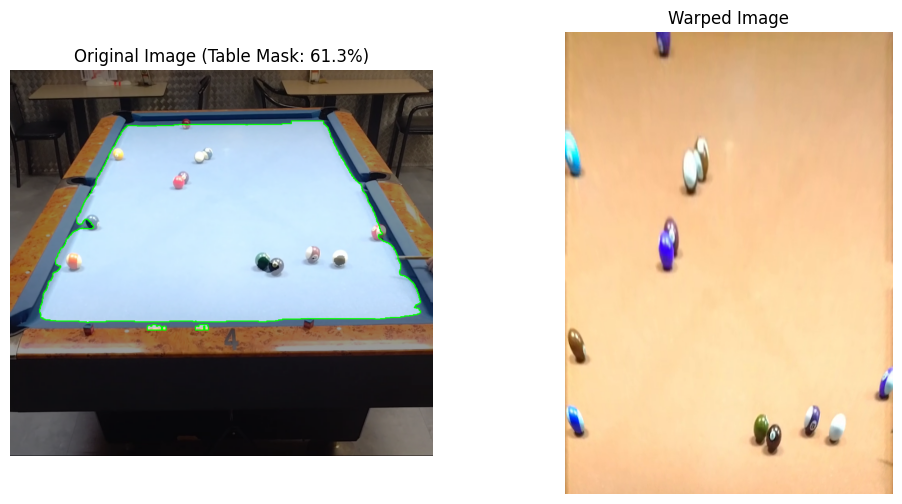

In [8]:
warp_image('test_data/test7.png')


image 1/1 c:\Users\Lenovo\Desktop\Machine Learning\Pool_Vision\test_data\test4.png: 576x640 1 table_play_area, 257.5ms
Speed: 4.7ms preprocess, 257.5ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 640)


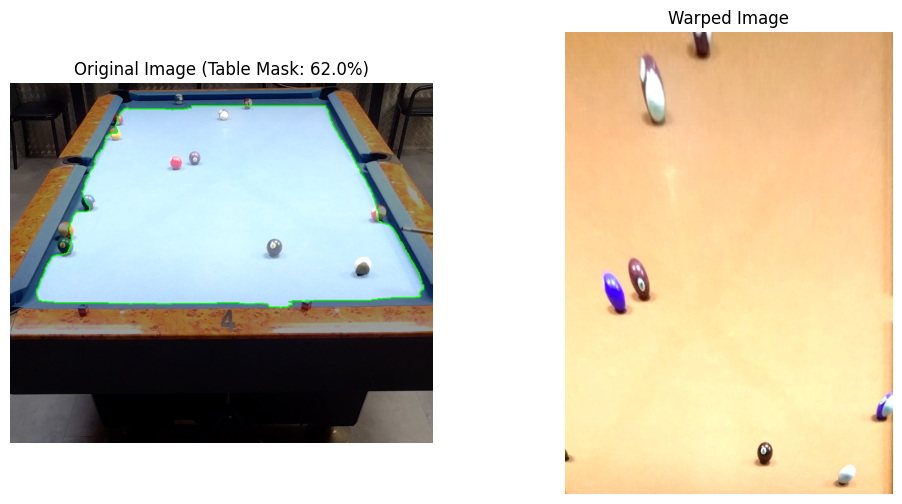

In [9]:
warp_image('test_data/test4.png')

In [ ]:
def mapping(image_path):
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Error: Could not read {image_path}")
        return

    img_height, img_width = img.shape[:2]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 1. Table segmentation
    table_results = table_model(image_path)[0]
    if not table_results.masks:
        print("No table segmentation found.")
        return

    mask = table_results.masks[0].data[0].cpu().numpy()
    mask_resized = cv2.resize(mask, (img_width, img_height))

    # Get largest contour & approximate
    contours, _ = cv2.findContours((mask_resized * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    epsilon = 0.05 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    if len(approx) != 4:
        print(f"Expected 4 corners, got {len(approx)}. Homography will not be applied.")
        return
    
    src_pts = order_points_stable([pt[0] for pt in approx])

    # Output image size
    width = 400
    height = int(width * 1.414)  # for A4
    # Desired points values in the output image
    dst_pts = np.float32([
        [0, 0], 
        [width, 0], 
        [0, height], 
        [width, height]
        ])
    
    H, _ = cv2.findHomography(src_pts, dst_pts)
    if H is None:
        print("Failed to compute homography matrix.")
        return
    
    # 2. Ball detection
    ball_results = ball_model(image_path)[0]
    mapped_positions, ball_labels = [], []

    # Perspective transformation
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    img_output = cv2.warpPerspective(img, matrix, (width, height))

    # 3. Visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # B. Table mask overlay
    mask_overlay = (mask_resized * 255).astype(np.uint8)
    mask_overlay_rgb = cv2.cvtColor(mask_overlay, cv2.COLOR_GRAY2RGB)
    blended = cv2.addWeighted(img_rgb, 0.6, mask_overlay_rgb, 0.4, 0)
    coverage_percent = (np.sum(mask > 0.5) / (height * width)) * 100

    # Draw all contours in green
    contour_img = blended.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

    # A. Original image with bounding boxes
    axs[0].imshow(contour_img)
    axs[0].set_title(f"Original Image (Table Mask: {coverage_percent:.1f}%)")
    axs[0].axis("off")

    axs[1].imshow(img_output)
    axs[1].set_title(f"Warped Image")
    axs[1].axis("off")

    

image 1/1 c:\Users\Lenovo\Desktop\Machine Learning\Pool_Vision\test_data\test4.png: 576x640 1 table_play_area, 241.4ms
Speed: 5.2ms preprocess, 241.4ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 640)


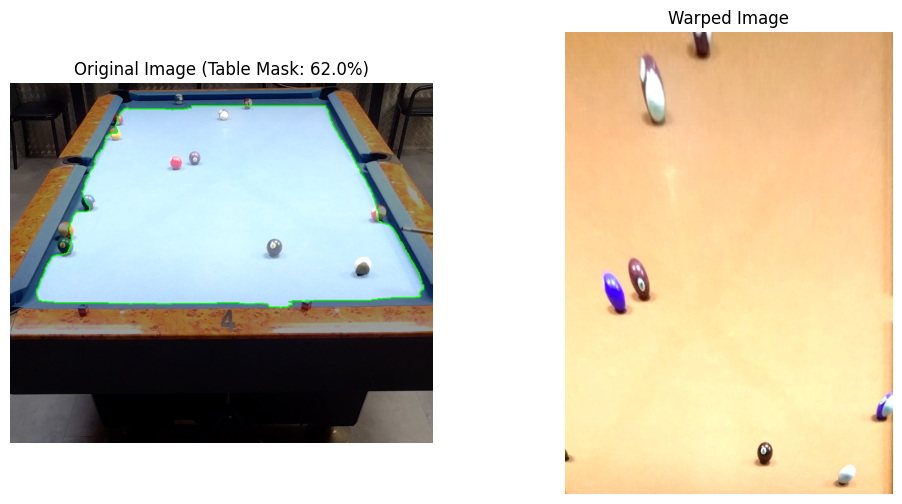

In [11]:
mapping('test_data/test4.png')